In [126]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [3]:
text = ['hey how are you','good i am fine','have a nice day','i feel very great']

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

In [4]:
print(char2int)

{' ': 0, 'n': 1, 'c': 2, 'h': 3, 'm': 4, 'a': 5, 'w': 6, 'y': 7, 'e': 8, 'l': 9, 'd': 10, 'u': 11, 'o': 12, 'i': 13, 't': 14, 'v': 15, 'f': 16, 'g': 17, 'r': 18}


In [5]:
maxlen = len(max(text, key=len))
print("The longest string has {} characters".format(maxlen))

The longest string has 17 characters


In [6]:
# Padding

# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i])<maxlen:
        text[i] += ' '

text

['hey how are you  ',
 'good i am fine   ',
 'have a nice day  ',
 'i feel very great']

In [7]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])

    # Remove firsts character for target sequence
    target_seq.append(text[i][1:])
    print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))



Input Sequence: hey how are you 
Target Sequence: ey how are you  
Input Sequence: good i am fine  
Target Sequence: ood i am fine   
Input Sequence: have a nice day 
Target Sequence: ave a nice day  
Input Sequence: i feel very grea
Target Sequence:  feel very great


In [8]:


for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]



In [9]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)

    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features



In [10]:
rnn = nn.GRU(10, 20, 2)
input = torch.randn(5, 1, 10)
h0 = torch.randn(2, 1, 20)
output, hn = rnn(input)#, h0)

In [11]:
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq.shape))


Input shape: (4, 16, 19) --> (Batch Size, Sequence Length, One-Hot Encoding Size)


In [12]:
input_seq

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtyp

In [13]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)


In [14]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")



GPU not available, CPU used


In [117]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)

        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden



In [16]:
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 500
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)




In [17]:
# Training Run
input_seq = input_seq.to(device)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(input_seq)
    output = output.to(device)
    target_seq = target_seq.to(device)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%50 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))



Epoch: 50/500............. Loss: 1.3820
Epoch: 100/500............. Loss: 0.3395
Epoch: 150/500............. Loss: 0.0956
Epoch: 200/500............. Loss: 0.0550
Epoch: 250/500............. Loss: 0.0420
Epoch: 300/500............. Loss: 0.0357
Epoch: 350/500............. Loss: 0.0321
Epoch: 400/500............. Loss: 0.0298
Epoch: 450/500............. Loss: 0.0283
Epoch: 500/500............. Loss: 0.0271


In [18]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character = character.to(device)

    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden



In [19]:
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)



In [20]:
sample(model, 15, 'good')

'good i am fine '

# RNN Example: approximate sin

In [128]:
x = torch.linspace(0,799, 800)
y = torch.sin(x * 2 * np.pi / 40)

In [209]:
class myLSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=50, out_size=1):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=False )
    self.linear = nn.Linear(hidden_size, out_size)
    self.hidden = (torch.zeros(1,2,hidden_size ) , torch.zeros(1,2,hidden_size)  )

  def forward(self, seq):
    lstm_out, self.hidden = self.lstm(seq.view( 40,2,-1 ), self.hidden )
    pred = self.linear(lstm_out.view(  40 ,2,-1 ))
    return pred[-1]

In [210]:
def create_sequences(data,window=10):
    N = data.size(0)
    return [(data[i:i+window],data[i+window]) for i in range(N-window)]


In [211]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]


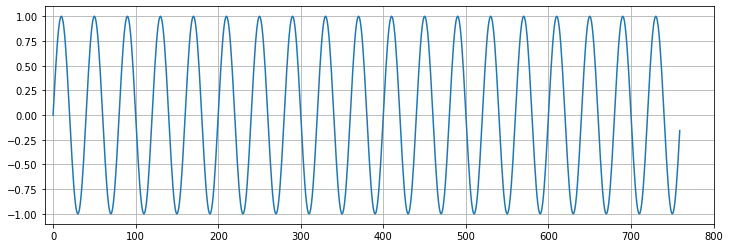

In [212]:
plt.figure(figsize = (12,4))
plt.xlim(-10, 801)
plt.grid(True)
plt.plot(train_set.numpy())

In [213]:
def input_data(seq, ws):
  output = []
  L = len(seq)
  for i in range((L) - ws):
    window = seq[i:i+ws]
    label = seq[i+ws:i+ws+1]
    print(i)
    output.append((window, label))

  return output

In [214]:
model = myLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
print(model)

myLSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [215]:
window_size = 40
train_data = input_data(train_set, window_size)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [216]:
for p in model.parameters():
  print(p.numel())

200
10000
200
200
50
1


In [219]:
model = myLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

epochs = 10
future = 40
for i in range(epochs):
  #for seq, y_train in train_data:
  #  optimizer.zero_grad()
  #  model.hidden = (torch.zeros(1,1,model.hidden_size) ,
  #                  torch.zeros(1,1,model.hidden_size))

   # y_pred = model(seq)
   # loss = criterion(y_pred, y_train)
   # loss.backward()
   # optimizer.step()

  for j in range(0,len(train_data),2):
      seq = torch.stack((train_data[j][0],train_data[j+1][0]),dim=0)
      y_train = torch.stack((train_data[j][1],train_data[j+1][1]),dim=0)
      optimizer.zero_grad()
      model.hidden = (torch.zeros(1,2,model.hidden_size) ,
                    torch.zeros(1,2,model.hidden_size))

      y_pred = model(seq)
      loss = criterion(y_pred, y_train)
      loss.backward()
      optimizer.step()

  print(f"Epoch {i} Loss {loss.item()} ")
 # preds = train_set[-window_size:].tolist()

 # for f in range(future):
 #   seq = torch.FloatTensor(preds[-window_size:])
 #   with torch.no_grad():
 #     model.hidden = (torch.zeros(1,2,model.hidden_size) ,
 #                     torch.zeros(1,2,model.hidden_size))
 #     preds.append(model(seq).item())
#
 # loss = criterion(torch.tensor(preds[-window_size :]), y[760:] )
 # print(f'Performance on test range: {loss}')

Epoch 0 Loss 0.034153349697589874 
Epoch 1 Loss 0.07986187934875488 
Epoch 2 Loss 0.055697306990623474 
Epoch 3 Loss 0.02633102796971798 
Epoch 4 Loss 0.007374752778559923 
Epoch 5 Loss 0.0017559088300913572 
Epoch 6 Loss 0.0007180558750405908 
Epoch 7 Loss 0.00050952477613464 
Epoch 8 Loss 0.00045454036444425583 
Epoch 9 Loss 0.000433095934567973 


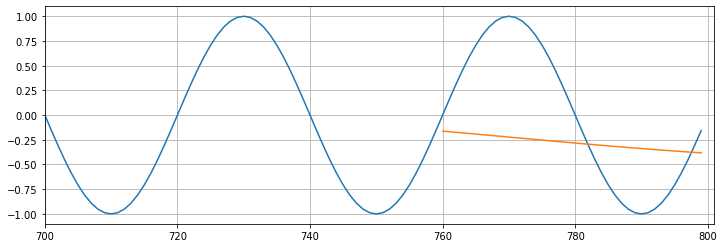

In [168]:
plt.figure(figsize=(12,4))
plt.xlim(700, 801)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(760,800), preds[window_size:])
plt.show()

In [177]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
a,b

(tensor([1, 2, 3]), tensor([4, 5, 6]))

In [179]:
torch.stack((a,b),dim=0)

tensor([[1, 2, 3],
        [4, 5, 6]])